# Imports

In [2]:
import numpy as np
import math
import schemdraw
import schemdraw.elements as elm
import random

# Genera Circuito

In [3]:
def dibujo_elemento(va):
  """
  Genera un número aleatorio entre 1 y 5 y devuelve un mensaje correspondiente.
  """
  numero_aleatorio = va
  if numero_aleatorio == 1:
    pass
  elif numero_aleatorio == 2:
    mensaje = elm.Line()
  elif numero_aleatorio == 3:
    mensaje = elm.Resistor()
  elif numero_aleatorio == 4:
    mensaje = elm.SourceV()
  else:  # numero_aleatorio == 5
    mensaje = elm.SourceI()

  return mensaje

# Ejemplo de uso:
#numero_aleatorio = random.randint(2, 5)
#mensaje_obtenido = obtener_mensaje_aleatorio(numero_aleatorio)
#print(mensaje_obtenido)

In [4]:
#para 1 malla
def generacircuito1malla(h,v):
    with schemdraw.Drawing() as d:
        d.config(unit=5)
        #izquierda vertical
        #x = dibujo_elemento(random.randint(2, 5))
        I1 = dibujo_elemento(v[0]).up().label(str(v[0]).replace('[', '').replace(']', ''), loc='bot')
        #I1 = elm.SourceV().label('20V')

        #superior horizontal
        HS = dibujo_elemento(h[0, 0]).right().label(str(h[0,0]).replace('[', '').replace(']', ''), loc='bot')
        #HS = elm.Resistor().right().label('400Ω')

        #derecha vertical
        D1 = dibujo_elemento(v[1]).down().label(str(v[1]).replace('[', '').replace(']', ''), loc='bot')
        #D1 = elm.SourceI().down().label('1A', loc='bot')

        #inferior horizontal
        #HI = elm.Line().left()
        HI = dibujo_elemento(h[1,0]).left().label(str(h[1,0]).replace('[', '').replace(']', ''), loc='bot')
        #elm.Dot()
        #d.push()
        #R3 = elm.SourceI().down().label('100Ω', loc='bot', rotate=True)
        #R2 = elm.Resistor().down().label('100Ω', loc='bot', rotate=True)
        #elm.Dot()
        #d.pop()
        #I0 = elm.SourceV().right().label('1A', loc='bot')
        #L1 = elm.Line()
        #I1 = elm.SourceI().down().label('1A', loc='bot')
        #I1 = elm.Line().down()
        #L2 = elm.Line().tox(V1.start)
        #L2 = elm.Resistor().left().label('400Ω')
        #L3 = elm.Line().left()
        #elm.LoopCurrent([R1,R2,L2,V1], pad=1.25).label('$I_1$')
        #elm.LoopCurrent([R1,I1,L2,R2], pad=1.25).label('$I_2$')    # Use R1 as top element for both so they get the same height



In [5]:
#para 2 mallas
def generacircuito2mallas(h,v):
    with schemdraw.Drawing() as d:
        d.config(unit=5)
        V1 = dibujo_elemento(v[0]).up().label('4')
        R1 = dibujo_elemento(h[0, 0]).right().label('0')
        #elm.Dot()
        d.push()
        R3 = dibujo_elemento(v[1]).down().label('5')
        #R2 = elm.Resistor().down().label('100Ω', loc='bot', rotate=True)
        #elm.Dot()
        d.pop()
        I0 = dibujo_elemento(h[0,1]).right().label('1')
        #L1 = elm.Line()
        #I1 = elm.SourceI().down().label('1A', loc='bot')
        I1 = dibujo_elemento(v[2]).down().label('6')
        #L2 = elm.Line().tox(V1.start)
        L2 = dibujo_elemento(h[1,1]).left().label('3')
        L3 = dibujo_elemento(h[1,0]).left().label('2')
        #elm.LoopCurrent([R1,R2,L2,V1], pad=1.25).label('$I_1$')
        #elm.LoopCurrent([R1,I1,L2,R2], pad=1.25).label('$I_2$')    # Use R1 as top element for both so they get the same height

# Funcion va

H:  [3 2]


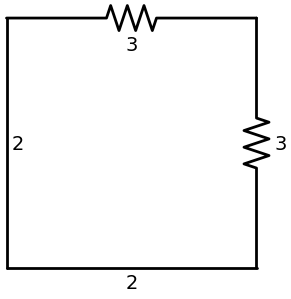

H:  [3 3 5 2]
V:  [[5]
 [2]
 [4]]


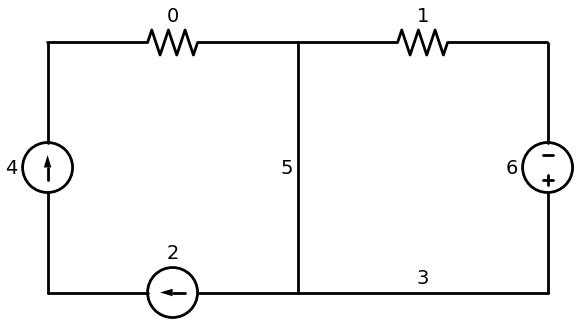

In [6]:

# Función equivalente a va(x, p, m, n) de MATLAB
def va(x, p, m, n):
    """
    Genera una matriz de m x n con elementos de x, siguiendo la distribución p.
    """
    return np.random.choice(x, size=(m, n), p=p)

# Ejemplo de prueba 1 malla
x = [2, 3, 4, 5]
p = [0.25, 0.25, 0.25, 0.25]
H = va(x, p, 2, 1)
V = va(x, p, 2, 1)

print("H: ",H.flatten())


generacircuito1malla(H,V)

# Ejemplo de prueba 2 mallas
x = [2, 3, 4, 5]
H = va(x, p, 2, 2)
V = va(x, p, 3, 1)

print("H: ",H.flatten())
print("V: ",V)

generacircuito2mallas(H,V)



# Actividad 1

In [7]:
# Simulación para la Actividad 1 (circuito de una malla)
# Evaluamos dos criterios de invalidez según las leyes de Kirchhoff

experimentos = 100_000
nocumple_corriente = 0
nocumple_24 = 0

for _ in range(experimentos):
    H = va(x, p, 1, 2)
    V = va(x, p, 1, 2)
    elementos = np.concatenate([H.flatten(), V.flatten()])

    # Criterio 1: más de una fuente de corriente (5)
    if np.sum(elementos == 5) > 1:
        nocumple_corriente += 1

    # Criterio 2: solo voltajes (4) y cortos (2), pero no todos cortos
    if np.all(np.isin(elementos, [2, 4])) and np.any(elementos == 4) and not np.all(elementos == 2):
        nocumple_24 += 1

# Resultados experimentales
fr_corriente = nocumple_corriente / experimentos
fr_24 = nocumple_24 / experimentos
fr_total = (nocumple_corriente + nocumple_24) / experimentos

# Resultados teóricos
total_combinaciones = 4**4  # 4 elementos, 4 opciones cada uno
# Combinaciones con 2 o más fuentes de corriente
inv_corriente = (
    (math.comb(4, 2) * 3**2) +  # 2 fuentes de corriente
    (math.comb(4, 3) * 3) +     # 3 fuentes de corriente
    1                              # 4 fuentes de corriente
)
teorico_corriente = inv_corriente / total_combinaciones

# Combinaciones con solo 2 y 4 (16 en total), excluyendo todos 2
teorico_24 = (2**4 - 1) / total_combinaciones
teorico_total = teorico_corriente + teorico_24

fr_corriente, fr_24, fr_total, teorico_corriente, teorico_24, teorico_total


(0.26179, 0.05814, 0.31993, 0.26171875, 0.05859375, 0.3203125)

# Actividad 2

In [19]:
# Simulación para la Actividad 2 (circuito de dos malla)
# Evaluamos tres criterios de invalidez según las leyes de Kirchhoff

# H, V, elementos_generados = generar_malla_valida()
# print(H, V, elementos_generados)

# Simulación
experimentos = 300_000
inv_fuentes_voltaje = 0
inv_fuentes_corriente = 0
inv_total = 0
inv_todas_resistencias = 1

for _ in range(experimentos):

    H = va(x, p, 1, 4).flatten()
    V = va(x, p, 1, 3).flatten()
    elementos = np.concatenate([H, V])

    # print("H: ", H.flatten())
    # print("V: ", V.flatten())
    # print("Elementos: ", elementos)

    ## P[V U I]=P[V]+P[I] - P[V n I]

    ## V1 = [0,2,4]
    ## V2 = [1,3,6]
    
    ## V3 = [4,5,6]
    
    malla_izq = np.array([elementos[i] for i in [0, 2, 4, 5]])
    malla_der = np.array([elementos[i] for i in [1, 3, 5, 6]])
    elem_medio = elementos[5]
    borde_malla = np.array([elementos[i] for i in [0,1,2,3,4,6]])

    # print("Malla Izq: ", malla_izq)
    # print("Malla Der: ", malla_der)
    # print("Borde Malla: ", borde_malla)
    # print("Elemento Medio: ", elem_medio)

    # Restricción 1: dos fuentes de voltaje en la misma malla
    corto = 2
    fuente_voltaje = 4
    fuente_corriente = 5
    invalido_voltaje = False
    invalido_corriente = False
    # --------- Malla izquierda [0,2,4] --------- #
    match np.sum(malla_izq == fuente_voltaje):
        case 1:
            if np.sum(malla_izq == corto) > 2:
                invalido_voltaje = True
        case 2:
            if np.sum(malla_izq == corto) > 1:
                invalido_voltaje = True
        case 3:
            if np.sum(malla_izq == corto) > 0:
                invalido_voltaje = True
        case 4:
            invalido_voltaje = True
    # --------- Malla derecha [1,3,6] --------- #
    match np.sum(malla_der == fuente_voltaje):
        case 1:
            if np.sum(malla_der == corto) > 2:
                invalido_voltaje = True
        case 2:
            if np.sum(malla_der == corto) > 1:
                invalido_voltaje = True
        case 3:
            if np.sum(malla_der == corto) > 0:
                invalido_voltaje = True
        case 4:
            invalido_voltaje = True
    # --------- Malla exterior --------- #
    match np.sum(borde_malla == fuente_voltaje):
        case 1:
            if np.sum(borde_malla == corto) > 4:
                invalido_voltaje = True
        case 2:
            if np.sum(borde_malla == corto) > 3:
                invalido_voltaje = True
        case 3:
            if np.sum(borde_malla == corto) > 2:
                invalido_voltaje = True
        case 4:
            if np.sum(borde_malla == corto) > 1:
                invalido_voltaje = True
        case 5:
            if np.sum(borde_malla == corto) > 0:
                invalido_voltaje = True
        case 6:
            invalido_voltaje = True

    if invalido_voltaje:
        inv_fuentes_voltaje += 1


    # Restricción 2: dos fuentes de corriente en la misma malla

    # Mallas sin el elemento compartido
    malla_izq2 = np.array([elementos[i] for i in [0, 2, 4]])
    malla_der2 = np.array([elementos[i] for i in [1, 3, 6]])
    
    if (np.sum(malla_izq2 == fuente_corriente) > 1 or np.sum(malla_der2 == fuente_corriente) > 1):
        invalido_corriente = True
    elif np.sum(malla_izq2 == fuente_corriente) == 1 and np.sum(malla_der2 == fuente_corriente) == 1 and elem_medio == fuente_corriente:
        invalido_corriente = True

    if invalido_corriente:
        inv_fuentes_corriente += 1
    
    if invalido_voltaje or invalido_corriente:
        inv_total += 1



# print("--------------------------------------------------")

print("Frecuencia invalidez voltaje: ", inv_fuentes_voltaje / experimentos)
print("Frecuencia invalidez corriente: ", inv_fuentes_corriente / experimentos)
print("Frecuencia invalidez total: ", inv_total )
print("Frecuencia invalidez total 2: ", inv_fuentes_corriente + inv_fuentes_voltaje)
inv_total = inv_fuentes_voltaje + inv_fuentes_corriente
fr_inv = inv_total / experimentos
fr_valido = 1 - fr_inv
print("Frecuencia inválida: ", fr_inv)
print("Frecuencia válida: ", fr_valido)

# ---------------------------------- Cálculo teórico -------------------

# # P[V] - Voltajes 
# # 1933 / 16384 = 0.118
# # P[I] - Corrientes
# # 5449 / 16384 = 0.333

# total_combinaciones = 4**7 ## 16384 combinaciones posibles (7 elementos, 4 opciones cada uno)

# ---------------------- Corrientes I -------------------

inval_corriente_izq = (
    ((math.comb(3, 2) * 3) +     # 2 fuentes de corriente en una malla
    1) *                         # 3 fuentes de corriente en una malla
    4**4                         # 4 opciones y 4 elementos en la otra malla
) # = 2560

inval_corriente_der = (
    ((math.comb(3, 2) * 3) +     # 2 fuentes de corriente en una malla
    1) *                         # 3 fuentes de corriente en una malla
    4**4                         # 4 opciones y 4 elementos en la otra malla
) # = 2560

# Superposición de fuentes de corriente en ambas mallas
# 10 formas inválidas por cada malla independiente = 10 * 10 * 4 = 100
# Invalidez = 2560 + 2560 - 100 = 5020

inval_corriente_medio = (
    (math.comb(3, 1) * 3**2) * # = 27 Exactamente 1 fuente de corriente en una malla
    (math.comb(3, 1) * 3**2) * # = 27 Exactamente 1 fuente de corriente en la otra malla
    1                          # 1 fuente de corriente en el medio
) # = 729


inv_corriente_medio = inval_corriente_der ** 2 * 1  # = 729


print("Invalidez por fuentes de corriente en una malla: ", inval_corriente_izq)
print("Invalidez por fuentes de corriente en el medio: ", inval_corriente_medio)
print("Invalidez total (corriente): ", (inval_corriente_izq + inval_corriente_der) - 400 + inval_corriente_medio) # = 5449

# ---------------------- Voltajes V -------------------

# Una malla (dos o más fuentes de voltaje)
inval_voltaje_izq = (
    (2 ** 4) *              # fuente de voltaje o corto (2 opciones) en cada posicion (4)
    4**3                     # 4 opciones y 3 posiciones restantes en la otra malla
) # = 16 * 64 = 1024

inval_voltaje_der = (
    (2 ** 4) *              # fuente de voltaje o corto (2 opciones) en cada posicion (4)
    4**3                     # 4 opciones y 3 posiciones restantes en la otra malla
) # = 16 * 64 = 1024

# 15 / 256 

inval_voltaje_ext = (
    (2 ** 6) *              # fuentes de voltaje o cortos (2 opciones) en cada posicion (6) 
    4**1                    # 4 opciones y 1 posicion restante (medio)
) # = 256

# 63 / 4096

# Invalidez = 1024 + 1024 + 256 = 


# C(4,2) = 4! / 2! (4-2)! = 6
# C(4,3) = 4! / 3! (4-3)! = 4

# Una malla (al menos una fuente de voltaje y el resto cortos)
# inval_voltaje_izq = (
#     ((math.comb(4, 1) * 2**3) +     # 2 fuentes de voltaje en una malla
#     1) *                            # 3 fuentes de voltaje en una malla
#     4**3                            # 4 opciones y 4 elementos en la otra malla
# ) # = 32 * 64 = 2048
print("Combinaciones de fuentes de voltaje en una malla: ", inval_voltaje_izq)
print("Combinaciones de fuentes de voltaje en la otra malla: ", inval_voltaje_der)
print("Combinaciones de fuentes de voltaje en el medio: ", inval_voltaje_ext)
print("Invalidez total (voltaje): ", inval_voltaje_izq + inval_voltaje_der + inval_voltaje_ext) # = 1984 1933

Frecuencia invalidez voltaje:  0.11835666666666667
Frecuencia invalidez corriente:  0.33274
Frecuencia invalidez total:  129934
Frecuencia invalidez total 2:  135329
Frecuencia inválida:  0.45109666666666665
Frecuencia válida:  0.5489033333333333
Invalidez por fuentes de corriente en una malla:  2560
Invalidez por fuentes de corriente en el medio:  729
Invalidez total (corriente):  5449
Combinaciones de fuentes de voltaje en una malla:  1024
Combinaciones de fuentes de voltaje en la otra malla:  1024
Combinaciones de fuentes de voltaje en el medio:  256
Invalidez total (voltaje):  2304


# Actividad 3

## Probabilidad condicional 1 malla

In [9]:
def prob_condicional(elementos, x):
    p = np.ones(len(x), dtype=float)

    # Regla 1: máximo una fuente de corriente
    if np.sum(np.array(elementos) == 5) >= 1:
        p[np.array(x) == 5] = 0

    # Regla 2: evitar que el circuito se forme solo con fuentes de voltaje y cortos
    # pero permitir si todos son cortos
    if len(elementos) == 3:
        # solo hay cortos (2) y voltajes (4)
        if all(e in [2, 4] for e in elementos):
            # si no hay cortos, no permitir más voltajes o cortos
            if 2 not in elementos:
                # todos son voltajes (no permitido)
                p[np.isin(x, [2, 4])] = 0
            # si hay fuentes de voltaje y no hay resistencias
            elif 4 in elementos and 3 not in elementos:
                # hay mezcla de 2 y 4, pero sin resistencias: no permitir más 2 ni 4
                p[np.isin(x, [2, 4])] = 0

    p = p / np.sum(p)
    return p

## Generador circuito de una malla